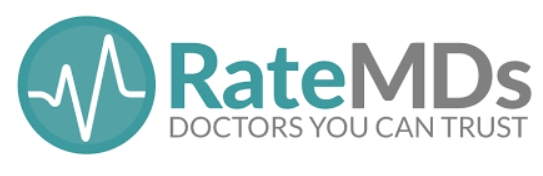

## Project Background:
The purpose of this project is to identify the trends and patterns in doctor's ratings based on their specialty, rank, previous ratings, gender, and other aspects. Additionally, analysis of patient's reviews to see if the doctors of a certain specialty face greater negative emotion compared to others. To perform the analysis I will first require the adequate data in the required format. And so I will perform website scraping of [RateMDs](https://www.ratemds.com/).

Two types of detail that will be scrapped from the website.
1. Basic Information:

   - Name
   - Specialist
   - Gender
   - Overall Rating
   - Rank
   - Profile Image(if exists?Y/N)
   
   
2. Doctor's Reviews:
   
   - Specialist
   - Gender
   - Overall Rating
   - Review Comments
   - Review Rating
   - How Useful?
   - Submission Date
   - Staff
   - Punctuality
   - Helpfulness
   - Knowledge
   
   
## Step by step approach to WebScraping:   
##### Step 1: Import the libraries.

In [11]:
#Import Webscraping Libraries
from bs4 import BeautifulSoup
import requests

#Import Data structure libraries
import pandas as pd
import numpy as np

##### Step 2: Accept website url to be scrapped in a variable.

In [5]:
#Enter url for scrapping (https://www.ratemds.com/best-doctors/)
site = input('Enter the url for scrapping: ')

Enter the url for scrapping: https://www.ratemds.com/best-doctors/ny/new-york/


##### Step 3: Write modular programs using functions to scrape each element of the data.

In [6]:
#Function web_list creates a list of doctor's web pages to be scrapped
def web_list(site):
    
    drpages = []
    
    pages = site + '?page='
    
    for num in range(1, 2):
        #Weblink to each next page
        link = pages + str(num)
        
        webcode = requests.get(link)
        webcontent = webcode.content
        
        #Parse webcontent through Html using BeautifulSoup 
        websoup = BeautifulSoup(webcontent, 'html.parser')
        dr_divcls = websoup.find_all("div", {"class": "search-item doctor-profile"})
        
        #Loop through each doctor's link
        for item in dr_divcls:
            try:
                dr_aclass = item.find("a", {"class": "search-item-doctor-link"})
                dr_href = dr_aclass.get('href')
                dr_link = "https://www.ratemds.com/"+dr_href
                drpages.append(dr_link)
            except:
                pass
    return drpages

In [7]:
web_list(site)

['https://www.ratemds.com//doctor-ratings/140581/Dr-David-Shusterman-Rego+Park-NY.html',
 'https://www.ratemds.com//doctor-ratings/3183031/Dr-Janan+S.-Sayyed-NEW+YORK-NY.html',
 'https://www.ratemds.com//doctor-ratings/141266/Dr-Bruce+S.-Hoffman-New+York-NY.html',
 'https://www.ratemds.com//doctor-ratings/871234/Dr-Michael+C.-Gartner-Paramus-NJ.html',
 'https://www.ratemds.com//doctor-ratings/dr-nigel-pereira-new-york-ny-us',
 'https://www.ratemds.com//doctor-ratings/dr-lesley-rabach-new-york-ny-us',
 'https://www.ratemds.com//doctor-ratings/3220016/Dr-SHU+PING-RONG-New+York-NY.html',
 'https://www.ratemds.com//doctor-ratings/3177266/Dr-IMAD+E.-AYOUBI-New+York-NY.html',
 'https://www.ratemds.com//doctor-ratings/3346561/Dr-ANDREW+D.-FRANGELLA-New+York-NY.html',
 'https://www.ratemds.com//doctor-ratings/136785/Dr-Douglas-Steinbrech-New+York-NY.html',
 'https://www.ratemds.com//doctor-ratings/2960786/Dr-Joshua-Zuckerman-Garden+City-NY.html']

#### Basic Doctor Details:
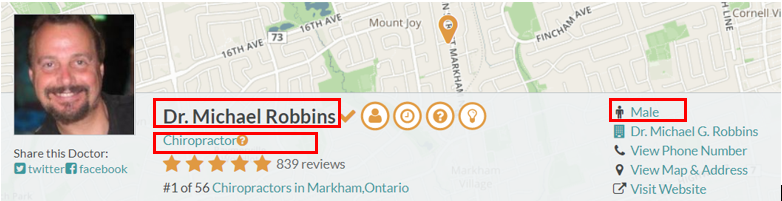

In [8]:
#Function dr_basics extracts information such as: Doctor's Name, Speciality and Gender
def dr_basics(drsoup):
    
    #Doctor Name
    drname_box = drsoup.find("h1", attrs={"itemprop": "name"})
    #.text is used to get text between Html tags value 
    dr_name = drname_box.text.strip() 
        
    #Doctor Specialities
    drspec_box = drsoup.find("div", attrs={"class":"search-item-info"})
    #.strip is used to remove starting and trailing
    dr_specialist = drspec_box.text.strip()
    
    #Doctor Gender
    drgend_box = drsoup.find("div", attrs={"class":"col-sm-3 col-md-4 search-item-extra"}).text
    dr_gender = drgend_box[1]
    
    return dr_name, dr_specialist, dr_gender

#### Doctor's Overall Rating and Rank:
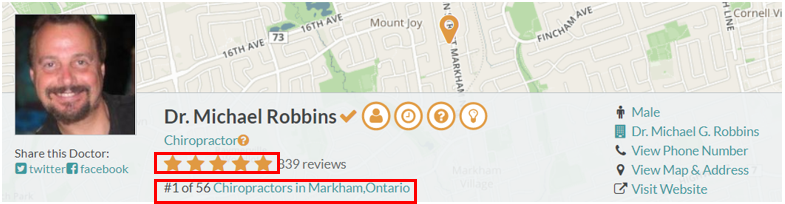

In [9]:
#Function dr_grading extracts information such as: Overall Rating and Rank in the region within their speciality
def dr_grading(drsoup):
    
    #Doctor's Overall Rating
    drrat_box = drsoup.find("span", attrs={"class":"star-rating"})
    overall_rating = drrat_box['title']
    
    #Doctor's rank among fellow doctors
    drrank_box1 = drsoup.find("div", attrs={"class":"col-sm-6"})
    drrank_box2 = drrank_box1.find_all("div", attrs={"class":"search-item-info"})
    
    for item in drrank_box2:
        if '#' in item.text:
            dr_rank = item.text
        
    return overall_rating, dr_rank

#### Does the Doctor's profile have a picture or no?
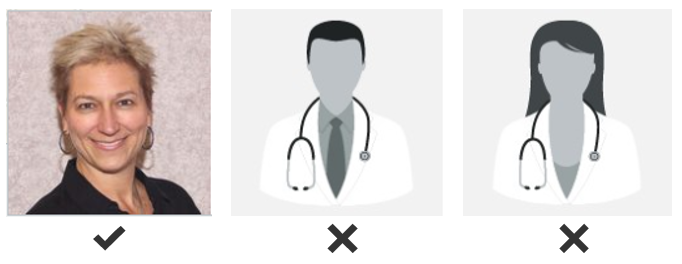

In [10]:
#Function dr_chkimage check if doctor's profile picture exists or not
def dr_chkimage(dr_url):
    imgcode = requests.get(dr_url)
    imgcont = imgcode.content
    imgsoup = BeautifulSoup(imgcont, 'html.parser')

    dr_imgbox = imgsoup.find_all("img")

    for item in dr_imgbox:
        if ('jpg' in item["src"]) and ('https' in item["src"]):
            return 'Y'
            break
        elif ('jpg' in item["src"]) and ('//www.ratemds.com/static/img/doctors/doctor-' in item["src"]):
            return 'N'
            break

##### Step 4: Create a main function that calls all the sub functions. The purpose of the main function is to collect, sync and store the data.

In [13]:
#Function dr_detail is the main function that calls all other functions to each of the doctors detail
data = []
def dr_detail(drpages):
    
    for i in range(0,len(drpages)):
        #Content for each doctor site
        drcode = requests.get(drpages[i])
        drcontent = drcode.content
        
        #Parse webcontent through Html using BeautifulSoup 
        drsoup = BeautifulSoup(drcontent, "html.parser")
        
        #Calling dr_basics function to get Name, Specialization and Gender details
        try:
            dr_name, dr_specialist, dr_gender = dr_basics(drsoup)
        except Exception:
            pass
        
        #Calling dr_grading function to get rating and ranking details
        try:
            overall_rating, dr_regionrank = dr_grading(drsoup)
        except Exception:
            pass
        
        #Calling dr_chkimage function to see if the doctor's profile has image or not
        try:
            dr_profileimage = dr_chkimage(drpages[i])
        except Exception:
            pass
        
        data.append((dr_name, dr_specialist, dr_gender,overall_rating, dr_regionrank,dr_profileimage,drpages[i]))
        
    return data        

##### Step 5: Create the dataframe with columns defined.

In [14]:
#Calling function web_list to get the list of doctors
drlist = web_list(site)

#Calling function dr_detail to get all the detail of each of the doctor
data1 = dr_detail(drlist)

#Creating a dataframe of all the details of doctor
df1 = pd.DataFrame.from_records(data1, columns =['Name', 'Specialist', 'Gender','Overall Rating', 'Rank','Profile Image(if exists?Y/N)','Link']) 

##### Step 6: Display part of the record using .head() method, to check data is if the data is as expected.

In [25]:
#Displaying extracted data
df1.head()

,Name,Specialist,Gender,Overall Rating,Rank,Profile Image(if exists?Y/N),Link
0,Dr. Janan S. Sayyed,Chiropractor,F,4.99,"#1 of 967 Chiropractors in New York City,New York",Y,https://www.ratemds.com//doctor-ratings/318303...
1,Bruce S. Hoffman,Psychologist,M,4.97,"#1 of 4133 Psychologists in New York City,New ...",Y,https://www.ratemds.com//doctor-ratings/141266...
2,Dr. Michael C. Gartner,"Plastic / Cosmetic Surgeon, Physician",M,4.95,"#1 of 21 Plastic / Cosmetic Surgeons, Physicia...",Y,https://www.ratemds.com//doctor-ratings/871234...
3,Dr. Nigel Pereira,Reproductive Endocrinologist,M,4.98,#1 of 158 Reproductive Endocrinologists in New...,Y,https://www.ratemds.com//doctor-ratings/dr-nig...
4,Dr. Lesley Rabach,"Plastic / Cosmetic Surgeon, Physician",F,4.99,"#2 of 535 Plastic / Cosmetic Surgeons, Physici...",Y,https://www.ratemds.com//doctor-ratings/dr-les...


##### Step 7: Use to_excel method to export the data into excel. 

In [15]:
#Exporting the data to an excel sheet
df1.to_excel("D:\Dr_Data_V1.0.xlsx",sheet_name='Sheet1', index=False)

--------------------------------------------------

#### Patient's reviews and ratings
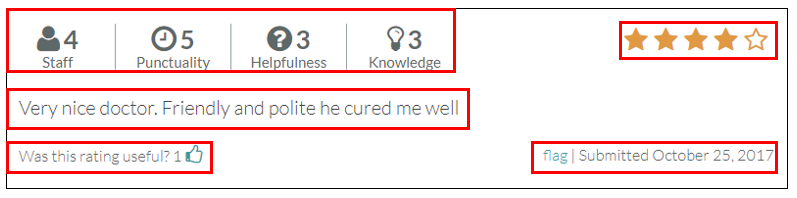

##### Step 8: For extracting review comments and ratings, perform steps 3-7. 

In [17]:
#Function dr_comments extracts evaluation, reviews, ratings and date of submission. It also pulls out if the review was useful.
def dr_comments(review_box):
    dr_comm = []
    
    for item in review_box:
        rev_rating = item.find("span", attrs={"class":"star-rating"})
        dr_comm.append((item.text,rev_rating['title']))
    return dr_comm

#### Number of pages of reviews: 
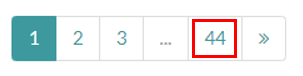

In [18]:
#Function dr_pages extracts number of review pages on each doctor's site.
def dr_pages(drsoup):
    
    try:
        pagination = drsoup.find("ul", attrs={"class":"pagination pagination-sm"})
        pages = [li.text for li in pagination.find_all('li')]
        lastpage = pages[-2]
    except:
        lastpage = 1
    
    return lastpage

In [19]:
#Function dr_reviews is the main function that calls all other functions to each of the doctors reviews and ratings
fulldata = []
def dr_reviews(drpages):
    
    for i in range(0,len(drpages)):
        
        #Content for each doctor site
        drcode = requests.get(drpages[i])
        drcontent = drcode.content

        #Parse webcontent through Html using BeautifulSoup 
        drsoup = BeautifulSoup(drcontent, "html.parser")
        
        #Calling dr_basics function to get Name, Specialization and Gender details
        try:
            dr_name, dr_specialist, dr_gender = dr_basics(drsoup)
            
        except Exception:
            pass

        #Calling dr_grading function to get rating and ranking details
        try:
            overall_rating, dr_regionrank = dr_grading(drsoup)
            
        except Exception:
            pass

        #Calling dr_chkimage function to see if the doctor's profile has image or not
        try:
            dr_profileimage = dr_chkimage(drpages[i])
            
        except Exception:
            pass

        
        try:
            last_page = dr_pages(drsoup)
            
        except:
            pass
        
        #Calling dr_basics function to get Name, Specialization and Gender details
        website = drpages[i] + '?page='

        num = int(last_page) if int(last_page) < 4 else 3

        for n in range(1,num+1):
            webpage = website + str(n)

            drrevcode = requests.get(webpage)
            drrevcont = drrevcode.content
            drrevsoup = BeautifulSoup(drrevcont, "html.parser")

            review_box = drrevsoup.find_all("div", attrs={"class":"rating"})

            try:
                temp_rev = dr_comments(review_box)
                
            except:
                pass
        
        
            for com in temp_rev:
                fulldata.append((dr_specialist, dr_gender,overall_rating, com[0],com[1]))
        
    return fulldata

In [20]:
#Calling function dr_reviews to get all the review details of each of the doctor
data2 = dr_reviews(drlist)

#Creating a dataframe of all the review details of doctor
df2 = pd.DataFrame.from_records(data2, columns =['Specialist', 'Gender','Overall Rating', 'Review Comments','Review Rating']) 

##### Step 9: Manupulate the data in the dataframe to get it in the required format. 

In [90]:
#Lambda functions are anonymous functions that take arguments and perform action iteratively. Syntax:lambda arguments : expression
df2['How Useful?'] = df2['Review Comments'].apply(lambda st: st[st.index("Was this rating useful? ")+24:st.find("| Submitted")])

In [96]:
# .split() is used to split the text. Syntax: txt.split(separator, maxsplit) 
#maxsplit (optional) tells to split the string into maximum of the provided number of times. 
df2['Submission Date'] = df2['Review Comments'].str.split(' Submitted ').str[1]
df2["Staff"] = df2['Review Comments'].str.split(' ').str[1]
df2["Punctuality"] = df2['Review Comments'].str.split(' ').str[2]
df2["Helpfulness"] = df2['Review Comments'].str.split(' ').str[3]
df2["Knowledge"] = df2['Review Comments'].str.split('Knowledge').str[0]
df2["Knowledge"] = df2["Knowledge"].str.split(' ').str[4]

In [133]:
df2['Review Comments'] = df2['Review Comments'].apply(lambda st: st[st.index("Knowledge")+9:st.find("Was this rating useful?")])

In [139]:
# .replace is used to replace string with other value 
#Syntax; DataFrame.replace(to_replace=None, value=None, inplace=False, limit=None, regex=False, method=’pad’, axis=None)
df2["Staff"] = df2["Staff"].str.replace('Staff','')
df2["Punctuality"] = df2["Punctuality"].str.replace('Punctuality','')
df2["Helpfulness"] = df2["Helpfulness"].str.replace('Helpfulness','')

In [140]:
df2.head()

,Specialist,Gender,Overall Rating,Review Comments,Review Rating,How Useful?,Submission Date,Staff,Punctuality,Helpfulness,Knowledge
0,Chiropractor,F,4.99,Dr. Janan Sayyed read my MRIs and explained to...,5.00,0 flag,"January 22, 2020",5,5,5,5
1,Chiropractor,F,4.99,I saw Dr. Janan Sayyed for Chiropractic care a...,5.00,0 flag,"January 20, 2020",5,5,5,5
2,Chiropractor,F,4.99,Dr. Janan Sayyed is an amazing healer. She has...,5.00,2 flag,"December 27, 2019",5,5,5,5
3,Chiropractor,F,4.99,Dr.Janan Sayyed is an awesome Chiropractor. I ...,5.00,2 flag,"December 18, 2019",5,5,5,5
4,Chiropractor,F,4.99,Dr. Sayyed is a very nice chiropractor. The st...,5.00,3 flag,"December 18, 2019",5,5,5,5


In [21]:
#Exporting the data to an excel sheet
df2.to_excel("D:\Dr_Reviews_V1.0.xlsx",sheet_name='Sheet1', index=False)

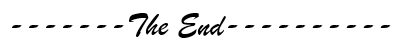